In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading in the dataset and viewing the first few rows
df = pd.read_csv('cleaned_fraud.txt')
df.head()

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,347788,11.945973,7.775082,0.262675,1.0,1.0,1.0,1.0,0.0
1,845764,39.264472,24.749645,1.956956,1.0,0.0,0.0,0.0,0.0
2,230977,1.367472,3.131729,0.572104,0.0,1.0,0.0,1.0,0.0
3,962271,31.484941,0.161098,3.648510,1.0,0.0,0.0,1.0,0.0
4,154305,5.311520,3.537440,6.569696,1.0,1.0,0.0,1.0,1.0


In [3]:
# Removing unwanted columns 
df = df.drop(columns=['Unnamed: 0'])

# Checking Logistic Regression Assumptions

- The target variable is binary - yes
- Independent observations - yes
- Large enough sample size - yes
- No influential outliers - dealt with during cleaning
- Outcome variable is balanced - will deal with using SMOTE
- No multicollinarity - will check and deal with

In [4]:
# Checking each observation is independent/unique
df.duplicated().sum()

0

In [5]:
# Checking the shape of the df to see the sample size
df.shape

(9616, 8)

In [6]:
# Checking how balanced the outcome variable is
df.fraud.value_counts()

fraud
0.0    8944
1.0     672
Name: count, dtype: int64

In [7]:
# Splitting the df into features and outcome variable
x = df.drop(columns=['fraud'])
y = df[['fraud']]

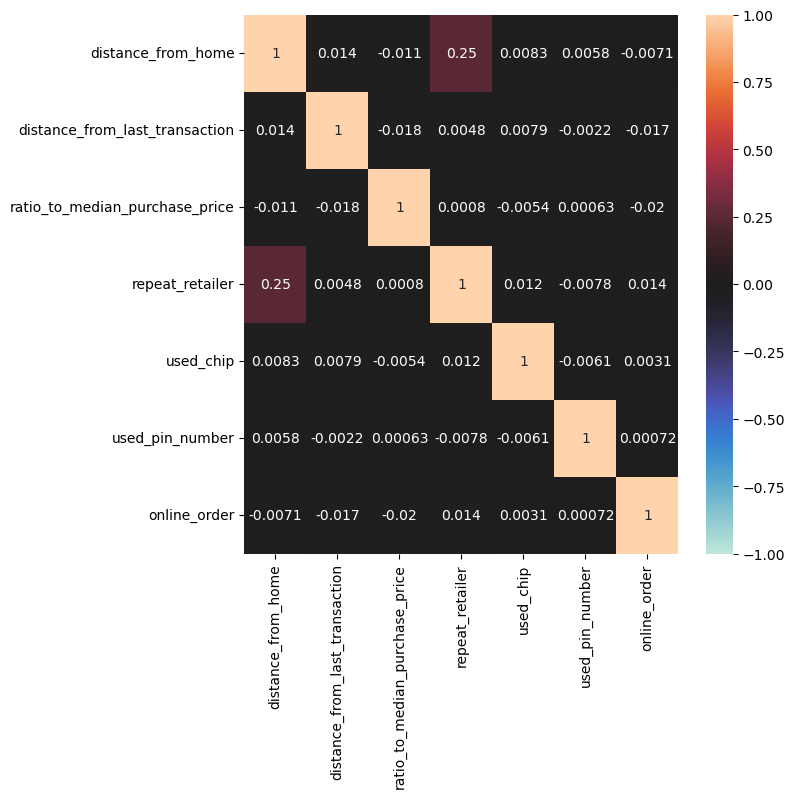

In [8]:
# Visualising the correlation between each feature
plt.figure(figsize=(7,7))
sns.heatmap(x.corr(), annot=True, vmin=-1, center=0, vmax=1)
plt.show()

# Train Test Split

In [9]:
# Splitting the features and outcome variable into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2, stratify=y)

# SMOTE

In [10]:
# Checking the counts in the outcome variable for the training data
y_train.value_counts()

fraud
0.0      7154
1.0       538
Name: count, dtype: int64

In [11]:
# Creating SMOTE model
sm = SMOTE(random_state=1, sampling_strategy= 'minority')

# Fitting and resampling the training data
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

# Checking the counts of the outcome variable for the training data after resampling
y_train_res.value_counts()

fraud
0.0      7154
1.0      7154
Name: count, dtype: int64

# Scaling

In [12]:
# Creating a standard scaler model
scaler = StandardScaler()

# Fitting the standard scaler to the training data and transforming it
x_train_scaled = scaler.fit_transform(x_train_res)

# Transforming the testing data with the standard scaler
x_test_scaled = scaler.transform(x_test)

# Logistic Regression Model

In [13]:
# Creating a logistic regression model
model = LogisticRegression(random_state=1, n_jobs=-1)

# Fitting the model to the training data
model.fit(x_train_scaled, y_train_res)

LogisticRegression(n_jobs=-1, random_state=1)

# Evaluating Model

In [14]:
# Getting the model score for the training data
print('Train Score')
print(model.score(x_train_scaled, y_train_res))

# Getting a model score for the testing data
print('Test Score')
print(model.score(x_test_scaled, y_test))

Train Score
0.9590438915292144
Test Score
0.9454261954261954


In [15]:
# Getting the predict outcomes from the training and testing data
y_pred_train = model.predict(x_train_scaled)
y_pred_test = model.predict(x_test_scaled)

In [16]:
# Getting the accuracy score for the model
accuracy = accuracy_score(y_test, y_pred_test)
print('Accuracy score is ' + str(accuracy))

# Getting the precision score for the model
precision = precision_score(y_test, y_pred_test)
print('Precision score is ' + str(precision))

# Getting the recall score for the model
recall = recall_score(y_test, y_pred_test)
print('Recall score is ' + str(recall))

# Getting the f1 score for the model
f1 = f1_score(y_test, y_pred_test)
print('F1 score is ' + str(f1))

Accuracy score is 0.9454261954261954
Precision score is 0.5656108597285068
Recall score is 0.9328358208955224
F1 score is 0.704225352112676


In [17]:
# Creating a confusion matrix to show the TN, FP, FN , TP
test_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_test), index=['Not Fraud', 'Fraud'], 
                                     columns=['Predicted Not Fraud', 'Predicted Fraud'])

test_confusion_matrix

,Predicted Not Fraud,Predicted Fraud
Not Fraud,1694,96
Fraud,9,125


# Hyperparameter Tuning

In [18]:
# Creating a range of C values for the grid search to use
c_array = np.logspace(-3, 2, 100)

# Putting all the hyperparameters into a dictionary for the gridsearch
tuned_parameters = [{'penalty':['l1', 'l2'], 'C':c_array, 'solver':['newton-cg', 'lbfgs', 'liblinear'],
                    'max_iter':[100,200]}]

# Creating a grid search model to find the best combinations of hyperparameters
grid_model = GridSearchCV(model, param_grid=tuned_parameters, scoring='recall', cv=5, verbose=2, n_jobs=-1)

# Fitting the gridsearch model to the training data
grid_model.fit(x_train_scaled, y_train_res)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-03, 1.12332403e-03, 1.26185688e-03, 1.41747416e-03,
       1.59228279e-03, 1.78864953e-03, 2.00923300e-03, 2.25701972e-03,
       2.53536449e-03, 2.84803587e-03, 3.19926714e-03, 3.59381366e-03,
       4.03701726e-03, 4.53487851e-03, 5.09413801e-03, 5.72236766e-03,
       6.4...
       1.74752840e+01, 1.96304065e+01, 2.20513074e+01, 2.47707636e+01,
       2.78255940e+01, 3.12571585e+01, 3.51119173e+01, 3.94420606e+01,
       4.43062146e+01, 4.97702356e+01, 5.59081018e+01, 6.28029144e+01,
       7.05480231e+01, 7.92482898e+01, 8.90215085e+01, 1.00000000e+02]),
                          'max_iter': [100, 200], 'penalty': ['l1', 'l2'],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear']}],
             scoring='recall', verbose=2)

In [19]:
# Finding out the best combinations of hyperparameters
print(grid_model.best_params_)

# Finding out the resulting score from those parameters after cross validation on the training set
print(grid_model.best_score_)

{'C': 0.004037017258596553, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.9828076605435095


# Tuned Model

In [20]:
# Creating a new logistic regression model with the tuned hyperparameters
tuned_model = LogisticRegression(penalty=grid_model.best_params_['penalty'], 
                                 C=grid_model.best_params_['C'], 
                                 solver=grid_model.best_params_['solver'], 
                                 max_iter=grid_model.best_params_['max_iter'],
                                 random_state=1, 
                                 n_jobs=-1)

# Fitting the tuned model to the training data
tuned_model.fit(x_train_scaled, y_train_res)

LogisticRegression(C=0.004037017258596553, n_jobs=-1, random_state=1,
                   solver='liblinear')

# Evaluating Tuned Model

In [21]:
# Finding the score for the training data 
print('Train Score')
print(tuned_model.score(x_train_scaled, y_train_res))

# Finding the score for the testing data
print('Test Score')
print(tuned_model.score(x_test_scaled, y_test))

Train Score
0.9579256360078278
Test Score
0.9360706860706861


In [22]:
# Getting the predictions from the tuned model for the training and testing sets
y_pred_train_tuned = tuned_model.predict(x_train_scaled)
y_pred_test_tuned = tuned_model.predict(x_test_scaled)

In [23]:
# Getting the accuracy score for the model
accuracy_2 = accuracy_score(y_test, y_pred_test_tuned)
print('Accuracy score is ' + str(accuracy_2))

# Getting the precision score for the model
precision_2 = precision_score(y_test, y_pred_test_tuned)
print('Precision score is ' + str(precision_2))

# Getting the recall score for the model
recall_2 = recall_score(y_test, y_pred_test_tuned)
print('Recall score is ' + str(recall_2))

# Getting the f1 score for the model
f1_2 = f1_score(y_test, y_pred_test_tuned)
print('F1 score is ' + str(f1_2))

Accuracy score is 0.9360706860706861
Precision score is 0.5219123505976095
Recall score is 0.9776119402985075
F1 score is 0.6805194805194805


In [24]:
# Creating a confusion matrix to show the TN, FP, FN , TP
test_tuned_confusion_matrix_2 = pd.DataFrame(confusion_matrix(y_test, y_pred_test_tuned), index=['Not Fraud', 'Fraud'], 
                                     columns=['Predicted Not Fraud', 'Predicted Fraud'])

test_tuned_confusion_matrix_2

,Predicted Not Fraud,Predicted Fraud
Not Fraud,1670,120
Fraud,3,131


In [25]:
# Checking the most impactful coefficients
coefs = pd.DataFrame(zip(x.columns, tuned_model.coef_[0]), columns=['Feature', 'Coef'])
coefs

,Feature,Coef
0,distance_from_home,1.062038
1,distance_from_last_transaction,0.495250
2,ratio_to_median_purchase_price,2.243956
3,repeat_retailer,-0.306552
4,used_chip,-0.227750
5,used_pin_number,-0.634292
6,online_order,0.997215


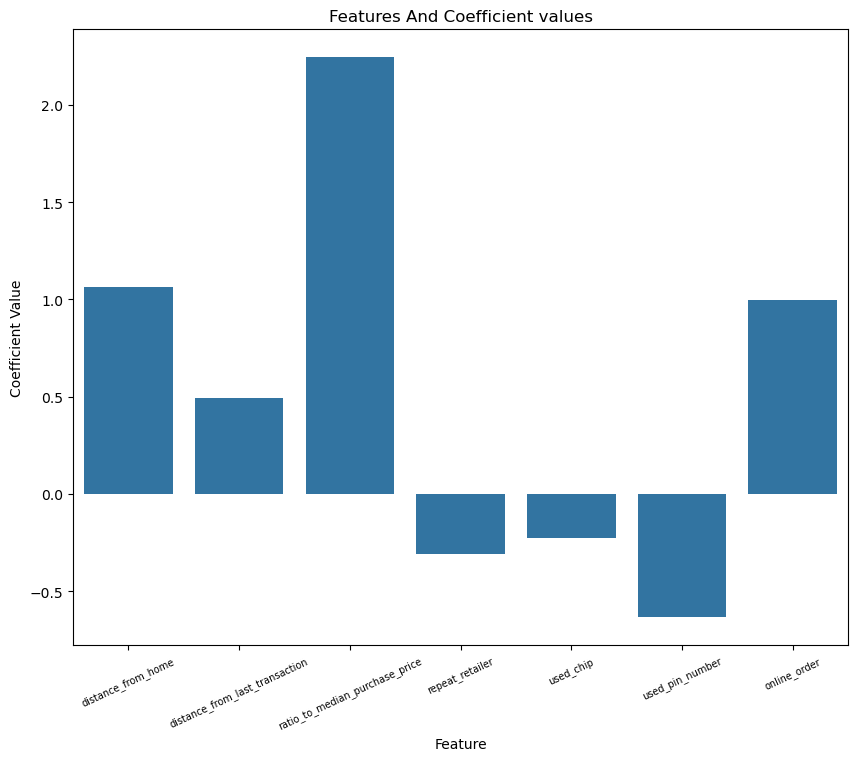

In [29]:
# Visualising the most impactful coefficients
plt.figure(figsize=(10,8))
sns.barplot(x=coefs.Feature, y=coefs.Coef)
plt.title('Features And Coefficient values')
plt.xlabel('Feature')
plt.xticks(rotation=25, size=7)
plt.ylabel('Coefficient Value')
plt.savefig('log_reg_coefficients.png')
plt.show()

# ROC Score And Thresholds

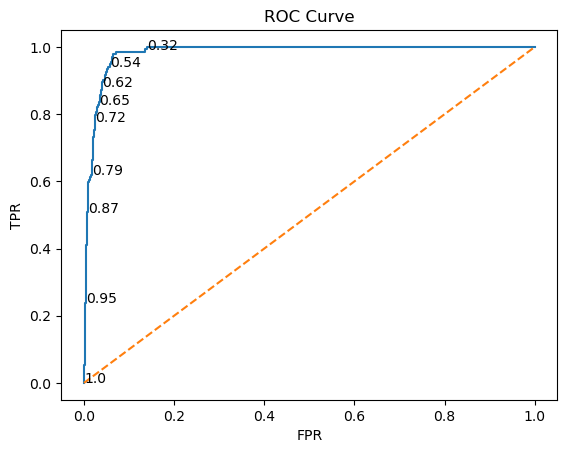

In [30]:
# Getting the probabilities of each outcome for the test set
y_pred_prob_test = tuned_model.predict_proba(x_test_scaled)

# Getting the true positive rate and false postive rate from the testing set
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob_test[:,1])

# Visualising the fpr and tpr 
plt.plot(fpr, tpr, label='ROC Curve')
idx = list(range(len(threshold)))[1::12]
for i in idx:
    plt.text(fpr[i], tpr[i], threshold[i].round(2))
    
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(x_train_scaled, y_train_res)
roc_auc = roc_auc_score(y_test, clf.predict_proba(x_test_scaled)[:,1])

clf_fpr, clf_tpr, clf_threshold = roc_curve(y_test, clf.predict_proba(x_test_scaled)[:,1])
plt.plot(clf_fpr, clf_tpr, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.savefig('log_reg_roc_curve.png')
plt.show()

In [31]:
# Finding the roc auc score
roc_auc_score_ = roc_auc_score(y_test, y_pred_prob_test[:,1])
roc_auc_score_

0.9827482698240639

In [32]:
# Finding the best threshold youlden stat, highest tpr
j_scores = tpr - fpr

# Youlden's J statistic
youlden_threshold = threshold[np.argmax(j_scores)]
print(youlden_threshold)

0.49033425864368824


In [33]:
# Creating a confusion matrix when the threshold youlden threshold
y_pred_youlden = (y_pred_prob_test[:,1] > youlden_threshold)*1.0
cm_youlden = confusion_matrix(y_test, y_pred_youlden)
print(cm_youlden)

[[1664  126]
 [   3  131]]


In [34]:
# Getting the accuracy and recall score for the model at the best threshold
accuracy_youlden = accuracy_score(y_test, y_pred_youlden)
print('Accuracy score is ' + str(accuracy_youlden))

recall_youlden = recall_score(y_test, y_pred_youlden)
print('Recall score is ' + str(recall_youlden))

Accuracy score is 0.932952182952183
Recall score is 0.9776119402985075


In [35]:
# Creating a function that will find the highest threshold that gets perfect recall
def recall_threshold(tuned_model, x_test_scaled, y_test):
    
    # Get predicted probabilities for the positive class
    y_pred_prob_test = tuned_model.predict_proba(x_test_scaled)[:, 1]
    
    # Initialize the best threshold as none
    best_threshold = None
    
    # Looping through threshold starting from 1 going to 0
    for threshold in np.linspace(1, 0, 100):
        
            # Getting binary predictions from the positive probabilities and thresholds
            y_pred = (y_pred_prob_test > threshold).astype(int)
            
            # Calculating recall score
            recall = recall_score(y_test, y_pred)
            
            # Checking to see if the recall score is perfect
            if recall == 1.0:
               best_threshold = threshold
               break  # Exit the loop once the perfect recall is found
                
    return best_threshold

In [36]:
# Highlighting the threshold that gets perfect recall
perfect_recall_threshold = recall_threshold(tuned_model, x_test_scaled, y_test)
print('The threshold that gets perfect recall is ' + str(perfect_recall_threshold))

The threshold that gets perfect recall is 0.31313131313131304


In [37]:
# Creating a confusion matirx when the threshold gets perfect recall
y_pred_perfect_recall = (y_pred_prob_test[:,1] > perfect_recall_threshold)*1.0
perfect_recall_confusion_matrix = confusion_matrix(y_test, y_pred_perfect_recall)
print(perfect_recall_confusion_matrix)

[[1539  251]
 [   0  134]]


# Learning Curve

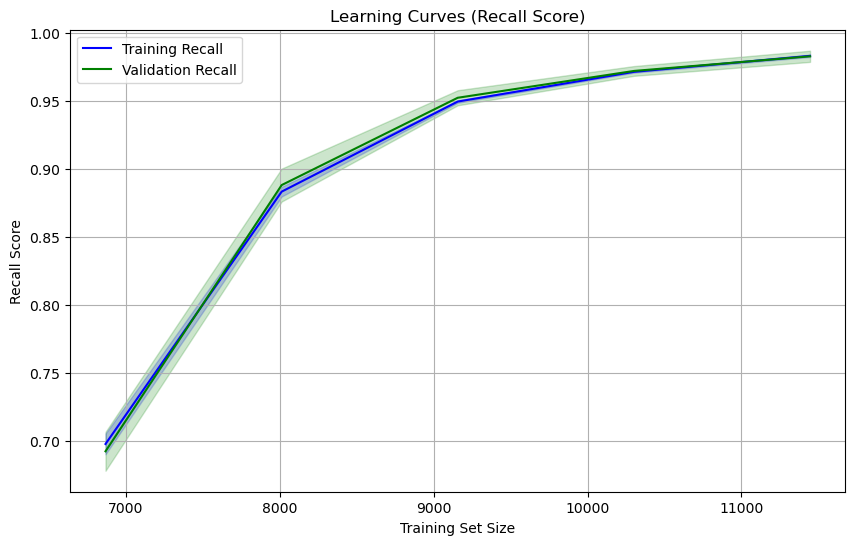

In [38]:
# Getting the learning curve data for the training and validation sets
train_sizes, train_scores, val_scores = learning_curve(tuned_model, x_train_scaled, y_train_res, cv=5, scoring='recall', 
                                                       train_sizes=np.linspace(0.1, 1.0, 10), random_state=1)

# Calculate the mean and std for the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Visualising the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Recall', color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Recall', color='green')

# Filling below and above the mean by 1 std for the training and validation sets
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, color='green', alpha=0.2)

plt.title('Learning Curves (Recall Score)')
plt.xlabel('Training Set Size')
plt.ylabel('Recall Score')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('log_reg_learning_curve.png')
plt.show()

# Making Predictions

In [39]:
# Features
# 'distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
# 'used_pin_number', 'online_order'

transaction_1 = np.array([10, 10, 1, 1, 0, 1, 0])
transaction_2 = np.array([20, 20, 2, 0, 1, 0, 1])
transaction_3 = np.array([50, 50, 3, 1, 0, 1, 0])
transaction_4 = np.array([100, 100, 5, 0, 0, 0, 1])

# Adding all the predictions into the same variable
fraud_pred = np.stack((transaction_1, transaction_2, transaction_3, transaction_4))

In [40]:
# Scaling the predictions so they match the tuned model scale
fraud_pred = scaler.transform(fraud_pred)

In [41]:
# Using the model to get the predictions
print(tuned_model.predict(fraud_pred))
print(tuned_model.predict_proba(fraud_pred))

# Transactions 2 and 4 were flagged as being potentially fradulent

[0. 1. 0. 1.]
[[9.98789119e-01 1.21088134e-03]
 [3.87195877e-01 6.12804123e-01]
 [9.10752377e-01 8.92476231e-02]
 [1.33101371e-04 9.99866899e-01]]
